# Post MCMC Fit

This notebook is to explore the degeneracy between inclination $i$ and accretion rate $\dot{M}$. Started 2 August 2019.

### Imports

In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import integrate
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from fu_ori_functions_oct11 import *
from fu_ori_classes_oct11 import *
import matplotlib.gridspec as gridspec

import emcee
import corner
import time
%matplotlib inline 

In [2]:
ATM_TABLE = dict()
ATMOS_FACTOR = 100

In [3]:
def direcToArray(directory):
    for temp in range(2000, 10000+ATMOS_FACTOR, ATMOS_FACTOR):
        for grav in [1.5, 4.0]:
            try:
                atmos_file = directory + 'pr.lte' + str(int(temp/ATMOS_FACTOR)) \
                        + '-' + str(grav) + '-0.0.spec'
                txt = open(atmos_file)
                fulltxt = txt.readlines()
                # Cleaning lines
                newtxt = []
                for i in range(len(fulltxt)):
                    line = fulltxt[i][:-1]
                    line = line.split()
                    newtxt.append(line)
        
                # Casting as floats
                newtxt = np.array(newtxt).astype(np.float64)
                
                # Choosing which model to use
                wav, lum = newtxt[:,0], newtxt[:,1]
                ATM_TABLE[(temp, grav)] = np.array([wav, lum])
            except:
                print('No atmosphere found for temp = ' + str(temp) + \
                      ' grav = ' + str(grav))

In [4]:
direcToArray('C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/')

No atmosphere found for temp = 7100 grav = 1.5
No atmosphere found for temp = 7100 grav = 4.0
No atmosphere found for temp = 7300 grav = 1.5
No atmosphere found for temp = 7300 grav = 4.0
No atmosphere found for temp = 7500 grav = 1.5
No atmosphere found for temp = 7500 grav = 4.0
No atmosphere found for temp = 7700 grav = 1.5
No atmosphere found for temp = 7700 grav = 4.0
No atmosphere found for temp = 7900 grav = 1.5
No atmosphere found for temp = 7900 grav = 4.0
No atmosphere found for temp = 8100 grav = 1.5
No atmosphere found for temp = 8100 grav = 4.0
No atmosphere found for temp = 8300 grav = 1.5
No atmosphere found for temp = 8300 grav = 4.0
No atmosphere found for temp = 8500 grav = 1.5
No atmosphere found for temp = 8500 grav = 4.0
No atmosphere found for temp = 8700 grav = 1.5
No atmosphere found for temp = 8700 grav = 4.0
No atmosphere found for temp = 8900 grav = 1.5
No atmosphere found for temp = 8900 grav = 4.0
No atmosphere found for temp = 9100 grav = 1.5
No atmosphere

In [5]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16

In [6]:
class FUOriEnvironment:
    
    # Initializer / Instance Attributes
    def __init__(self, wave_lower_SED, wave_upper_SED):
        
        self.wave_lower_SED = wave_lower_SED
        self.wave_upper_SED = wave_upper_SED
        
        # Storing classes
        self.fuori = 0
        
#         print('Created environment.')
        
    # instance methods
    
    # Creating FU Ori object as accretion disk
    def createFUOri(self, r_star, r_outer, m_star, m_dot, inc, dist, grav, direc, a_v, atm_table):
#         print('Creating FU Ori object...')
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v, atm_table)
#         print('Creating disk annuli...')
        fuori.setAnnuliValues(10000, 2000, 200, 2*R_STAR)
#         print('Reading stellar atmosphere directory...')
        fuori.createAnnuliFromDirec(grav, direc, 'stellar atmospheres')
#         print('Preparing annuli for broadening and summing...')
        fuori.prepareAnnuli(self.wave_lower_SED,self.wave_upper_SED, \
                            binning=100, broaden=False, interp_type='linear')
#         print('Creating model spectrum...')
        fuori.createModelSpectrum('stellar atmospheres', broaden=False)
#         print('FU Ori object created.')
        self.fuori = fuori
    
    def createFUOriBB(self, r_star, r_outer, m_star, m_dot, inc, dist, grav, direc, a_v, atm_table):
#         print('Creating FU Ori object...')
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v, atm_table)
#         print('Creating disk annuli...')
        fuori.setAnnuliValues(10000, 2000, 100, 0.1*R_STAR)
#         print('Reading stellar atmosphere directory...')
        fuori.createAnnuliBlackbody(np.arange(self.wave_lower_SED, self.wave_upper_SED, 10))
#         print('Preparing annuli for broadening and summing...')
#         fuori.prepareAnnuli(self.wave_lower_spec,self.wave_upper_spec, \
#                             binning=1, broaden=False, interp_type='linear')
#         print('Creating model spectrum...')
        fuori.createModelSpectrum('blackbodies', broaden=False)
#         print('FU Ori object created.')
        self.fuori = fuori
    
    # For viewing model spectrum
    def viewModelSpectrum(self, wave_lower, wave_upper, redden):
            return self.fuori.viewModelSpectrum(wave_lower, wave_upper, False, redden)
    def getModSpecPoint(self, wave, redden):
        return np.mean(self.viewModelSpectrum(wave-10, wave+10, redden)[1])

### Making an instance of the class

In [7]:
M_STAR = (10**-0.09)*M_SUN
R_STAR= 0.35*R_SUN
R_OUTER = 40 * R_STAR
M_DOT = (10**-1.12) * 1e-6 * M_SUN / 3.154e7


INC = 60.

DIST = 1.27e3*3.08567758128e18
DIREC = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/'

In [8]:
gaia17bpi_env = FUOriEnvironment(3.5e3, 50e3)
gaia17bpi_envbb = FUOriEnvironment(3.5e3, 50e3)
%time gaia17bpi_env.createFUOri(r_star = R_STAR, r_outer = R_OUTER, m_star = M_STAR,\
                          m_dot = M_DOT, inc = INC, dist = DIST, grav = 1.5, direc = DIREC, a_v=3, atm_table=ATM_TABLE)
%time modSpec = gaia17bpi_env.viewModelSpectrum(3e3, 5e4, True)

%time gaia17bpi_envbb.createFUOriBB(r_star = R_STAR, r_outer = R_OUTER, m_star = M_STAR,\
                          m_dot = M_DOT, inc = INC, dist = DIST, grav = 1.5, direc = DIREC, a_v=3, atm_table=ATM_TABLE)
%time modSpecbb = gaia17bpi_envbb.viewModelSpectrum(3e3, 5e4, True)

Wall time: 160 ms
Wall time: 4 ms
Wall time: 160 ms
Wall time: 20 ms


In [9]:
gaia17bpi_env.getModSpecPoint(21708.395735656377, True)

1.0533342292569647e+37

In [10]:
wav, lum = modSpec
wavbb, lumbb = modSpecbb

In [11]:
PATH = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Papers/Gaia 17bpi/'

DIST = 1.27e3*3.08567758128e18

### Reading in data points

In [12]:
log_lam_OPT = np.array([-0.41337227, -0.38837227, -0.36337227, -0.33837227, -0.31337227,
        -0.28837227, -0.26337227, -0.23837227, -0.21337227, -0.18837227,
        -0.16337227, -0.13837227, -0.11337227, -0.08837227, -0.06337227,
        -0.03837227, -0.01337227,  0.01162773,  0.03662773,  0.06162773,
         0.08662773,  0.11162773,  0.13662773,  0.16162773,  0.18662773,
         0.21162773,  0.23662773,  0.26162773,  0.28662773,  0.31162773,
         0.33662773,  0.36162773, 0.525, 0.6628])
log_lam_F_OPT = np.array([-13.02132686, -12.7475307 , -12.51653431, -12.32042641,
        -12.15237163, -12.0065403 , -11.87803826, -11.76283666,
        -11.65770177, -11.56012473, -11.46825142, -11.38081221,
        -11.29705178, -11.21665889, -11.13969624, -11.06653018,
        -10.99776061, -10.93415069, -10.8765567 , -10.82585779,
        -10.78288584, -10.7483552 , -10.72279252, -10.70646653,
        -10.69931788, -10.70088888, -10.71025335, -10.72594638,
        -10.74589417, -10.76734379, -10.78679299, -10.79992002, -11.17, -11.35])
log_lam_F_OPT_ERR = -0.01*log_lam_F_OPT

In [13]:
10**log_lam_OPT

array([0.38603593, 0.40891   , 0.43313944, 0.45880456, 0.48599044,
       0.51478719, 0.54529025, 0.57760073, 0.61182572, 0.64807867,
       0.68647975, 0.72715623, 0.77024295, 0.81588271, 0.8642268 ,
       0.91543546, 0.96967842, 1.02713548, 1.08799708, 1.15246496,
       1.2207528 , 1.29308695, 1.36970717, 1.45086743, 1.53683672,
       1.62790003, 1.72435917, 1.82653387, 1.93476281, 2.04940471,
       2.17083957, 2.29946991, 3.34965439, 4.60044666])

### Plotting data with model

In [14]:
x_mod = np.log10(wav*1e-4)
y_mod = np.log10(lum*wav*1e-8*np.cos(np.radians(INC))/(2*np.pi*DIST**2))

x_bb = np.log10(wavbb*1e-4)
y_bb = np.log10(lumbb*wavbb*1e-8*np.cos(np.radians(INC))/(2*np.pi*DIST**2))

f = np.polyfit(x_mod, y_mod, 5)
h,e,d,c,b,a = f
g = lambda x: a + b*x + c*x**2 + d*x**3 + e*x**4 +h*x**5
x_new = np.arange(min(x_mod), max(x_mod), 0.025)
y_new = g(x_new)

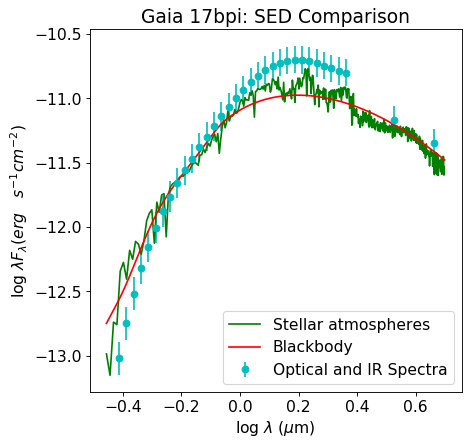

In [15]:
fig=plt.figure(figsize=(6, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})


plt.plot(x_mod,y_mod , 'g-', label='Stellar atmospheres')
# plt.plot(x_new,y_new , 'red', label='Polynomial Fit')

plt.errorbar(log_lam_OPT, log_lam_F_OPT, yerr=log_lam_F_OPT_ERR, marker='o', \
             linestyle='', color='c',label='Optical and IR Spectra')
plt.plot(x_bb,y_bb , 'r', label='Blackbody')
plt.xlabel(r'log $\lambda$ ($\mu$m)')
plt.ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')
plt.title('Gaia 17bpi: SED Comparison')
# plt.ylim(-15, -10)
# plt.xlim(-0.8, 1.8)
plt.legend()
plt.show()

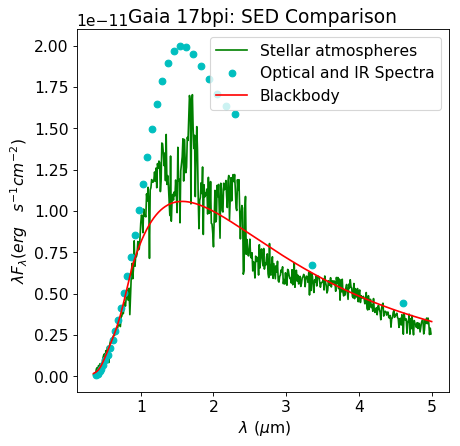

In [16]:
fig=plt.figure(figsize=(6, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})


plt.plot(10**x_mod,10**y_mod , 'g-', label='Stellar atmospheres')
# plt.plot(x_new,y_new , 'red', label='Polynomial Fit')

plt.plot(10**log_lam_OPT, 10**log_lam_F_OPT, marker='o', \
             linestyle='', color='c',label='Optical and IR Spectra')
plt.plot(10**x_bb,10**y_bb , 'r', label='Blackbody')
plt.xlabel(r' $\lambda$ ($\mu$m)')
plt.ylabel(r'$\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')
plt.title('Gaia 17bpi: SED Comparison')
# plt.ylim(-15, -10)
# plt.xlim(-0.8, 1.8)
plt.legend()
plt.show()